In [18]:
import sys
sys.path.append("..\\scripts\\")
import torch 
from astropy.io import fits
from astropy.visualization import ImageNormalize, AsinhStretch
import numpy as np
import matplotlib.pyplot as plt
from torch.func import vmap, grad
from tqdm import tqdm
from scipy.stats import binned_statistic_2d
import mpol.constants as const
from mpol import coordinates

plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 10
from score_models import ScoreModel, NCSNpp
import json

plt.style.use("dark_background")

from utils import fits_to_tensor
device = "cuda" if torch.cuda.is_available() else "cpu"

# Importing the models hparams and weights
file = open("../../ncsnpp_ct_g_220912024942/model_hparams.json")
model_hparams = json.load(file)
sigma_min, sigma_max = model_hparams["sigma_min"], model_hparams["sigma_max"]

# Importing the weights
score_model = ScoreModel(checkpoints_directory="../../ncsnpp_ct_g_220912024942")

In [27]:
# Just take the first spectral window: 
data = np.load("../../HTLup_continuum_full.npz")

u = data["uu"]
v = data["vv"]
vis = data["data"]
weight = data["weight"]
vis_per_spw = data["vis_per_spw"]


def grid(pixel_scale, img_size): 
    """Given a pixel scale and a number of pixels in image space, grid the associated Fourier space

    Args:
        pixel_scale (float): Pixel resolution (in arcsec)
        img_size (float/int): Size of the image 

    Returns:
        
    """

    # Arcsec to radians: 
    dl = pixel_scale * const.arcsec
    dm = pixel_scale * const.arcsec

    du = 1 / (img_size * dl) * 1e-3 # klambda
    dv = 1 / (img_size * dm) * 1e-3 # klambda

    u_min = -img_size//2 * du 
    u_max = img_size//2 * du 

    v_min = -img_size//2 * dv
    v_max = img_size//2 * dv

    u_edges = np.linspace(u_min, u_max, img_size + 1)
    v_edges = np.linspace(v_min, v_max, img_size + 1)

    return u_edges, v_edges

pixel_scale = 0.0015
img_size = 256
u_edges, v_edges = grid(pixel_scale = pixel_scale, img_size = img_size)


In [25]:
def flip(x):
    return x[:, ::-1]

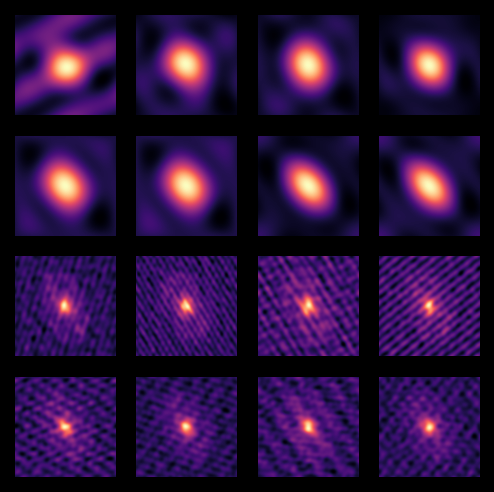

In [28]:
indices = vis_per_spw.cumsum()
fig, axs = plt.subplots(4, 4, figsize = (4, 4))
spw = 0
dirty_images = []
for i in range(4):
    for j in range(4): 
        if spw == 0: 
            idx_inf = 0
        else: 
            idx_inf = indices[spw-1]

        u = data["uu"]
        v = data["vv"]
        vis = data["data"]
        weight = data["weight"]
        vis_per_spw = data["vis_per_spw"]

        idx_sup = indices[spw]
        u = u[idx_inf:idx_sup]
        v = v[idx_inf:idx_sup]
        vis = vis[idx_inf:idx_sup]
        weight = weight[idx_inf:idx_sup]

        uu = np.concatenate([u, u])
        vv = np.concatenate([v, v])

        vis_re = np.concatenate([vis.real, vis.real])
        vis_imag = np.concatenate([vis.imag, vis.imag])
        weight_ = np.concatenate([weight, weight])

        bin_x = u_edges
        bin_y = v_edges
        vis_gridded_re, edgex, edgey, binnumber = binned_statistic_2d(vv, uu, vis_re, "mean", (bin_y, bin_x))
        vis_gridded_img, edgex, edgey, binnumber = binned_statistic_2d(vv, uu, vis_imag, "mean", (bin_y, bin_x))

        std_gridded_re, edgex, edgey, binnumber = binned_statistic_2d(vv, uu, vis_re, "std", (bin_y, bin_x))
        std_gridded_img, edgex, edgey, binnumber = binned_statistic_2d(vv, uu, vis_imag, "std", (bin_y, bin_x))

        count, edgex, edgey, binnumber = binned_statistic_2d(vv, uu, vis_imag, "count", (bin_y, bin_x))

        vis_gridded_re[np.isnan(vis_gridded_re)] = 0
        vis_gridded_img[np.isnan(vis_gridded_img)] = 0


        std_gridded_re[np.isnan(std_gridded_re)] = 0
        std_gridded_img[np.isnan(std_gridded_img)] = 0

        vis_grid = vis_gridded_re + 1j * vis_gridded_img
        spw +=1

        dirty_image = flip(np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(vis_grid))))
        dirty_images.append(dirty_image)
        axs[i, j].imshow(dirty_image.real, cmap = "magma")
        axs[i, j].axis("off")

In [44]:
from fast_histogram import histogram2d as fast_hist

(-0.5, 255.5, -0.5, 255.5)

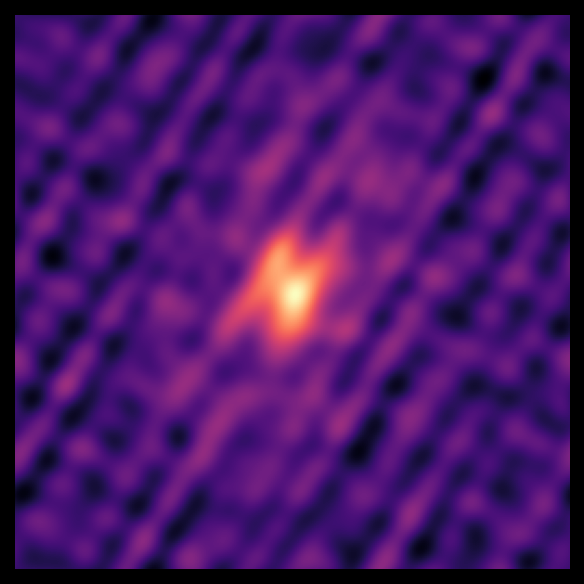

In [43]:
u = data["uu"]
v = data["vv"]
vis = data["data"]
weight = data["weight"]
vis_per_spw = data["vis_per_spw"]

spw = 10
idx_inf = indices[spw - 1]
idx_sup = indices[spw]
u = u[idx_inf:idx_sup]
v = v[idx_inf:idx_sup]
vis = vis[idx_inf:idx_sup]
weight = weight[idx_inf:idx_sup]

uu = np.concatenate([u, u])
vv = np.concatenate([v, v])

vis_re = np.concatenate([vis.real, vis.real])
vis_imag = np.concatenate([vis.imag, vis.imag])
weight_ = np.concatenate([weight, weight])

bin_x = u_edges
bin_y = v_edges
vis_gridded_re, edgex, edgey, binnumber = binned_statistic_2d(vv, uu, vis_re, "mean", (bin_y, bin_x))
vis_gridded_img, edgex, edgey, binnumber = binned_statistic_2d(vv, uu, vis_imag, "mean", (bin_y, bin_x))

std_gridded_re, edgex, edgey, binnumber = binned_statistic_2d(vv, uu, vis_re, "std", (bin_y, bin_x))
std_gridded_img, edgex, edgey, binnumber = binned_statistic_2d(vv, uu, vis_imag, "std", (bin_y, bin_x))

count, edgex, edgey, binnumber = binned_statistic_2d(vv, uu, vis_imag, "count", (bin_y, bin_x))

vis_gridded_re[np.isnan(vis_gridded_re)] = 0
vis_gridded_img[np.isnan(vis_gridded_img)] = 0


std_gridded_re[np.isnan(std_gridded_re)] = 0
std_gridded_img[np.isnan(std_gridded_img)] = 0

vis_grid = vis_gridded_re + 1j * vis_gridded_img


dirty_image = flip(np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(vis_grid))))
plt.imshow(dirty_image.real, cmap = "magma", origin = "lower")
plt.axis("off")

In [32]:
dirty_bottom = dirty_images[8:]

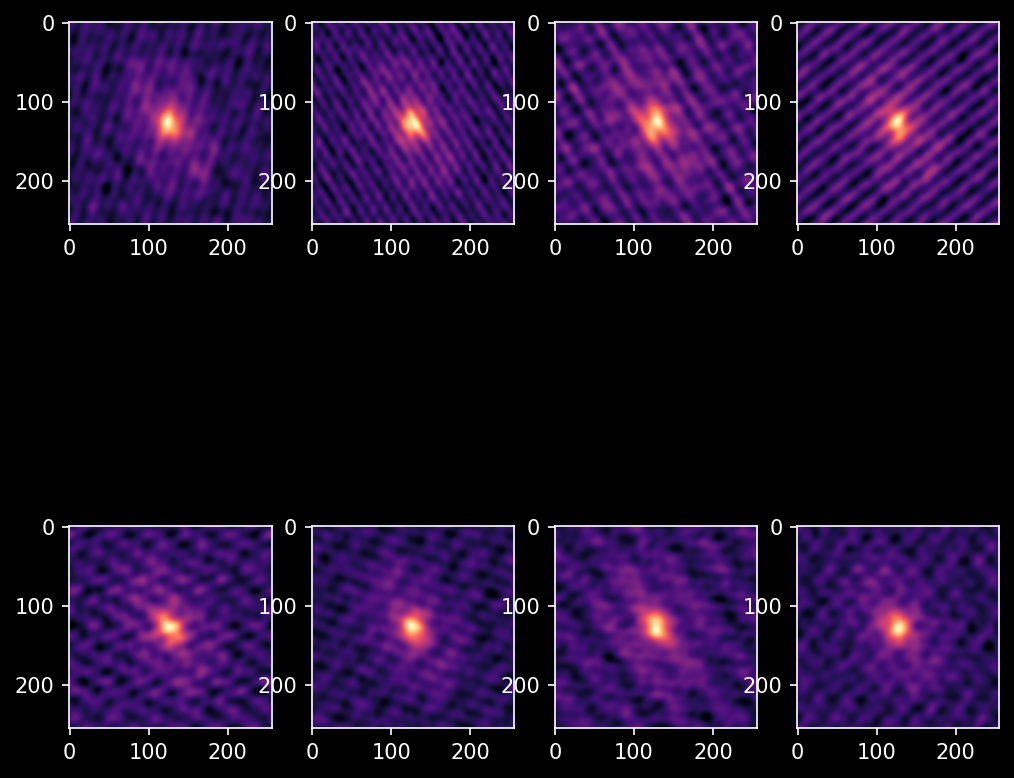

In [34]:
fig, axs = plt.subplots(2, 4, figsize = (8, 8))


k = 0
for i in range(2): 
    for j in range(4): 
        axs[i, j].imshow(dirty_bottom[k].real, cmap = "magma")
        k += 1

In [39]:
dirty = np.array(dirty_bottom)

In [40]:
dirty.shape

(8, 256, 256)

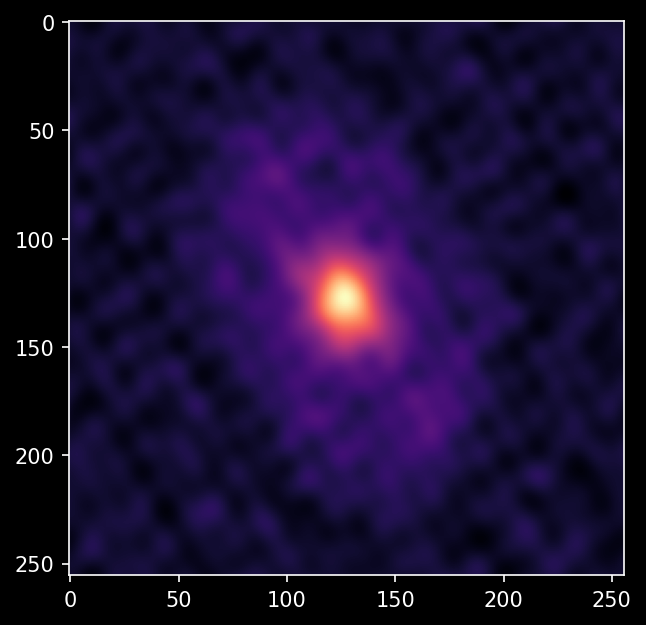

In [41]:
plt.imshow(dirty.mean(axis = 0).real, cmap = "magma")